**Random Forest**

In this analysis, we explore the use of Random Forest, an ensemble learning method, to predict daily exchange rates. Random Forest builds upon the concept of decision trees, combining multiple trees to improve predictive accuracy and reduce the risk of overfitting. 

By leveraging the strength of multiple decision trees, Random Forest aims to capture complex patterns in the data while maintaining robustness to variations.

Import necessary libraries for the analysis

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

Import the data from the csv file and inspect it

In [3]:
# Import the CAD=X currency pair data from the CSV file
df = pd.read_csv('cad_x_currency_data.csv', index_col=0)
df

,Ticker,Open,High,Low,Close,Adj Close,Time
Date,,,,,,,
2008-08-01,CAD=X,1.02340,1.02940,1.02290,1.02460,1.02460,2
2008-08-04,CAD=X,1.02800,1.03680,1.02620,1.03640,1.03640,8
2008-08-05,CAD=X,1.03630,1.04480,1.03630,1.04260,1.04260,14
2008-08-06,CAD=X,1.04260,1.04930,1.04000,1.04750,1.04750,20
2008-08-07,CAD=X,1.04760,1.05330,1.04490,1.05200,1.05200,26
...,...,...,...,...,...,...,...
2023-07-24,CAD=X,1.32240,1.32276,1.31542,1.32240,1.32240,38937
2023-07-25,CAD=X,1.31746,1.32095,1.31466,1.31746,1.31746,38947
2023-07-26,CAD=X,1.31871,1.32352,1.31720,1.31871,1.31871,38957


In [4]:
df.shape

(3905, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3905 entries, 2008-08-01 to 2023-07-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     3905 non-null   object 
 1   Open       3905 non-null   float64
 2   High       3905 non-null   float64
 3   Low        3905 non-null   float64
 4   Close      3905 non-null   float64
 5   Adj Close  3905 non-null   float64
 6   Time       3905 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 244.1+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Time
count,3905.000000,3905.000000,3905.000000,3905.000000,3905.000000,3905.000000
mean,1.198423,1.202731,1.194271,1.198412,1.198412,19457.018438
std,0.136652,0.136947,0.136378,0.136623,0.136623,11274.606568
min,0.943000,0.947200,0.940600,0.943200,0.943200,2.000000
25%,1.049800,1.054770,1.044800,1.049800,1.049800,9693.000000
50%,1.254420,1.259230,1.250170,1.254400,1.254400,19458.000000
75%,1.315860,1.319310,1.312870,1.315800,1.315800,29218.000000
max,1.458030,1.468730,1.449370,1.457800,1.457800,38977.000000


In [7]:
# Check for missing values in each column
missing_values = df.isna().sum()
print(missing_values)

Ticker       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Time         0
dtype: int64


Check the shape of the dataframe, get info about the datatypes of the columns. Then also check for missing values using .isna

**Feature Engineering**

In this section, we enhance our dataset with additional features derived from the original data. Moving averages are commonly used in financial time series analysis to smooth out short-term fluctuations and highlight longer-term trends. We calculate two moving averages for the closing prices:



In [8]:
# Calculate moving averages
df['MA10'] = df['Close'].rolling(window=10).mean() #10-day moving average
df['MA50'] = df['Close'].rolling(window=50).mean() #50-day moving average

**10-day Moving Average (MA10):** This short-term moving average provides insight into the recent price trend and can help identify short-term momentum. It is calculated as the average of the closing prices over the past 10 days.

**50-day Moving Average (MA50):** This longer-term moving average offers a broader view of the price trend over a more extended period. It is useful for identifying long-term trends and potential support or resistance levels. It is calculated as the average of the closing prices over the past 50 days.

The calculation of moving averages introduces null values in the initial rows of our dataset, as there are not enough data points to compute the average for these periods. 

To address this, we backfill the missing values, using the next valid observation to fill the gap.

In [9]:
# Since moving averages introduce NaN values for the initial rows, we need to handle these rows
# Backfill null values
df = df.fillna(method='bfill')
# df_clean = df.dropna()

In [10]:
# Display the first few rows of the dataframe with new features
df.head()

,Ticker,Open,High,Low,Close,Adj Close,Time,MA10,MA50
Date,,,,,,,,,
2008-08-01,CAD=X,1.0234,1.0294,1.0229,1.0246,1.0246,2,1.05333,1.06213
2008-08-04,CAD=X,1.0280,1.0368,1.0262,1.0364,1.0364,8,1.05333,1.06213
2008-08-05,CAD=X,1.0363,1.0448,1.0363,1.0426,1.0426,14,1.05333,1.06213
2008-08-06,CAD=X,1.0426,1.0493,1.0400,1.0475,1.0475,20,1.05333,1.06213
2008-08-07,CAD=X,1.0476,1.0533,1.0449,1.0520,1.0520,26,1.05333,1.06213


In [11]:
df.shape

(3905, 9)

**Feature Selection**

In this step, we define the set of features to be used for modeling. Along with the original predictors 'Open', 'High', 'Low', and 'Adj Close', we include the engineered features 'MA10' and 'MA50', which represent the 10-day and 50-day moving averages, respectively. These features are expected to provide valuable insights into the short-term and long-term trends in the closing prices.

In [12]:
# List of features to include moving averages and any other predictors you've identified
features_columns = ['Open', 'High', 'Low', 'Adj Close', 'MA10', 'MA50']

# Features
X = df[features_columns]

# Target variable
y = df['Close']


**Train-test split chronological**

To evaluate the performance of our Random Forest model, we split the dataset into training and testing sets in a chronological manner. This approach preserves the temporal order of the data, which is crucial for time series analysis. We allocate 80% of the data for training and the remaining 20% for testing.



In [13]:
# Calculate the index for the split
split_idx = int(len(df) * 0.8)

In [14]:
# Split the features
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]

In [15]:
# Split the target
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3124, 6), (781, 6), (3124,), (781,))

The split results in 3,124 observations for the training set and 781 observations for the testing set, with each set containing six features. 

**Hyperparameter Optimization**

To enhance the performance of our Random Forest model, we conduct hyperparameter optimization using GridSearchCV. 

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the model
rf = RandomForestRegressor()

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best estimator (model)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


After fitting GridSearchCV on the training data, the best parameters found are {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}. These parameters are used to initialize the best model, which will be further evaluated on the testing set to assess its predictive performance.

By optimizing the hyperparameters, we aim to build a more accurate and generalizable Random Forest model that can effectively capture the underlying patterns in the exchange rate data.



**Model Evaluation**

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions
predictions = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

print(f"RMSE: {rmse}, MAE: {mae}")


RMSE: 0.00016288561056634695, MAE: 9.838778826093785e-05


In [19]:
from sklearn.metrics import r2_score

# Calculate R-squared on the testing set
r_squared = r2_score(y_test, predictions)

print(f"R-squared: {r_squared}")


R-squared: 0.9999856100900618


After optimizing the hyperparameters of our Random Forest model, we evaluate its performance on the testing set. The evaluation metrics used are:

**Root Mean Squared Error (RMSE):** This metric provides an indication of the magnitude of the prediction errors, with a lower value indicating better model performance. For our model, the RMSE is approximately 0.00016.

**Mean Absolute Error (MAE):** This metric measures the average magnitude of the errors in the predictions, without considering their direction. The MAE for our model is approximately 9.71e-05.

**R-squared:** This metric suggests that model explains the variability of the data very close to 1, which is near perfect scores at first glance. However, this would make it a poor model to depend on to generalize well on unseen data.

These metrics suggest that the optimized Random Forest model achieves a high level of accuracy in predicting the exchange rates. The low values of RMSE and MAE indicate that the model's predictions are very close to the actual values, demonstrating its effectiveness for this dataset.

**Plot the actual and predicted values for train and test split**

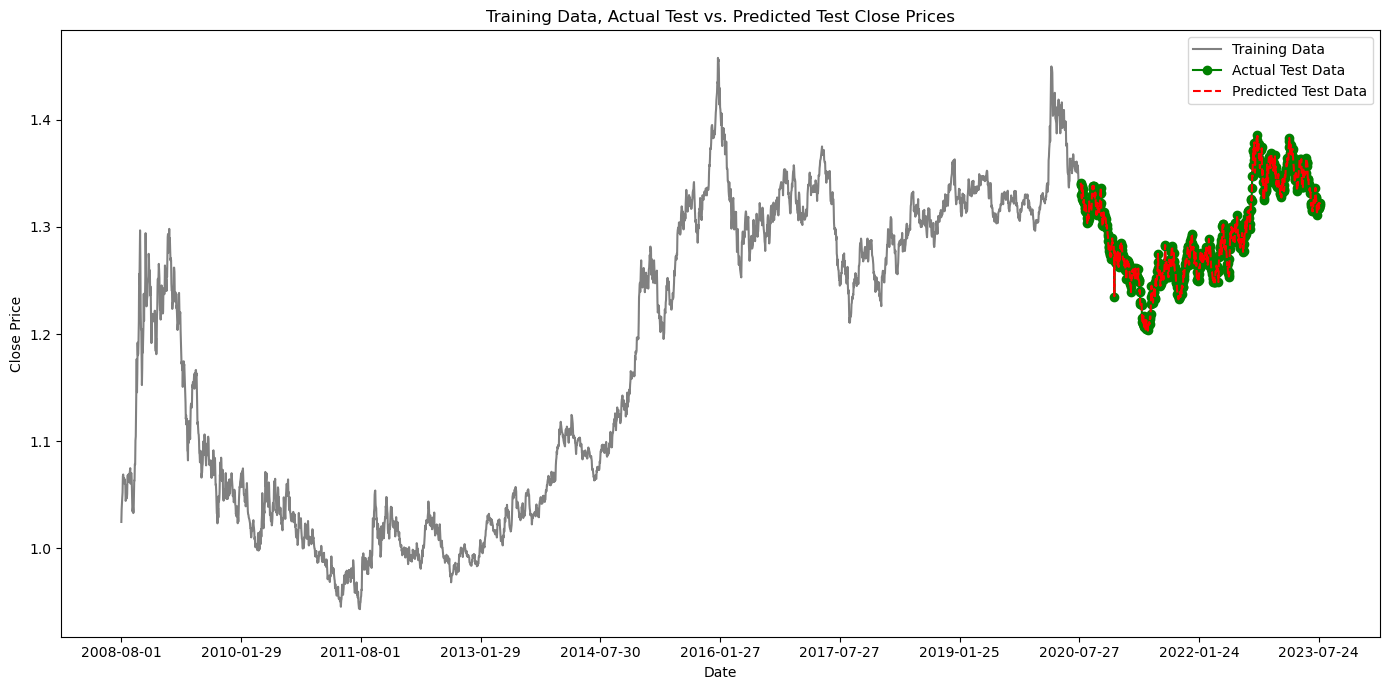

In [20]:
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(df.index[:split_idx], y_train, label='Training Data', color='gray')

# Plot testing data
plt.plot(df.index[split_idx:split_idx+len(y_test)], y_test, label='Actual Test Data', color='green', marker='o')

# Plot predictions on the test set
plt.plot(df.index[split_idx:split_idx+len(y_test)], predictions, label='Predicted Test Data', color='red', linestyle='--')

plt.title('Training Data, Actual Test vs. Predicted Test Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Display fewer x-ticks
tick_spacing = int(len(df.index) / 10)  # display a tick every 10% of the dataset length
plt.xticks(df.index[::tick_spacing])

plt.tight_layout()
plt.show()


From a visual inspection, it appears that the predicted values very close to test data points. However, similar to decision trees, the variables are **strong base variables** which leads to a model that is unable to generalize well for unseen data.

**Plot the errors for visual inspection**

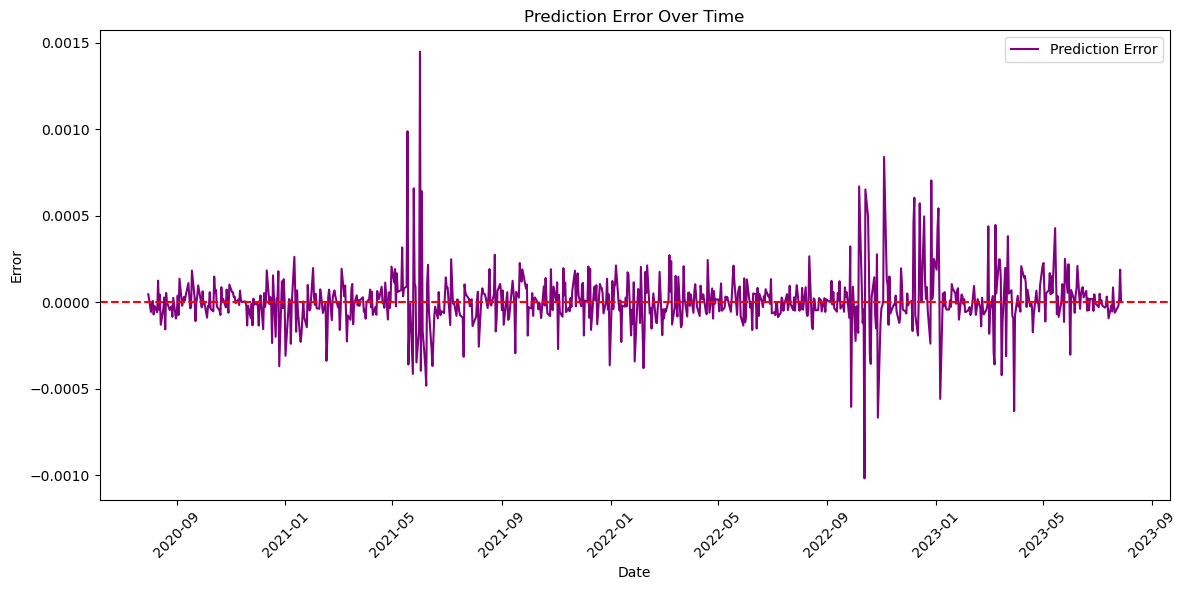

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate errors
errors = y_test - predictions

plt.figure(figsize=(12, 6))

# Plot errors over time
plt.plot(df.index[split_idx:split_idx+len(y_test)], errors, label='Prediction Error', color='purple')
plt.axhline(y=0, color='r', linestyle='--')  # Optional: baseline at 0

# Format the dates on the x-axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)  # Rotate the dates for better visibility

plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Prediction Error Over Time')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


In the plot above, we see the errors distributed around the zero line, with occasional spikes indicating larger deviations from the actual values. A dense clustering around the zero line would suggest that errors are generally low, which is indicative of a model with good predictive accuracy. The presence of spikes might point to instances where the model's predictions are less accurate, possibly due to unusual market conditions or outliers in the data. Although, the highest spike is 0.0015, which appears like a small spike, but it explains the volatility in the data.

**Conclusion**

The remarkably high R-squared of the Random Forest model in predicting the closing rates raises questions about the practicality of these results. Given the numerical similarity between the 'Open', 'High', 'Low', and 'Close' rates, the predictor variables may offer an almost perfect forecast that, while statistically appealing, may not fully capture the unpredictable nature of real-world financial markets.